# 1. Imports
Nothing interesting here. 💤💤💤💤💤💤💤💤💤💤💤💤💤💤💤 ok stop sleeping there is also the rest of the notebook to walkthrough😜

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Efficientnet stuff
import efficientnet.tfkeras as efn
# Tensorflow Stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.backend as K
# Data Splitting Stuff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
# Image Handler Stuff
import matplotlib.pyplot as plt
import cv2
# Array Handler Stuff
import numpy as np
# Other stuff
import os
from tqdm import tqdm as tqdm
from functools import partial
import math
import re

Bunccha good ideas - 

https://www.kaggle.com/tuckerarrants/cassava-tensorflow-starter-training on mixup
https://www.kaggle.com/dimitreoliveira/cassava-leaf-supervised-contrastive-learning on contrastive learning

Good article - 
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet

# 2. TPU SETUP

Here are some excellent notebooks to refer - 
https://www.kaggle.com/awsaf49/efficientnetb6-512-cutmixupdropout-tpu-train

https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease/data

https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-training-with-tpu-v2-pods/notebook

https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tpu-tensorflow-training

Other good notebooks but on gpu - 

https://www.kaggle.com/frlemarchand/efficientnet-aug-tf-keras-for-cassava-diseases

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
replicas = strategy.num_replicas_in_sync
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


Some setup variables

The GCS Path thingy stuff explaination-

**TPUs read data directly from Google Cloud Storage (GCS), so we actually need to copy our dataset to a GCS 'bucket' that is near or 'co-located' with the TPU. The below chunk of code accomplishes this using the handy KaggleDatasets:**

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * replicas
IMAGE_SIZE = [512, 512]
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 5
CLASSES = ['0', '1', '2', '3', '4']
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
print(GCS_PATH)
print(BATCH_SIZE)

gs://kds-be94128ce773ab53f24c9b0a2aced4ad5bde5fc04d38f200b1c23181
16


# 3. Loading in our data

Some excellent notebooks on tfrecords

https://www.kaggle.com/ryanholbrook/tfrecords-basics

We are gonna load our data via tfrecords. Now tfrecords as tensorflow suggests is best to feed data to a TPU. So we are gonna go with that.🙂

 ### 1. Decode Image Function and Stuff
The following is a decoding function what it does is takes in an image in jpg form and converts it into an array.

In [5]:
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

Well if you do not want to spend alot of time in understanding how tfrecords work just pick up other people's code use that to load data and then train and move forward.😜

### 2. Scaling
The following just changes the image type to float and divides the image by 255 to normalize it

In [6]:
def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label


### 3. Resizing our images
Just resizes and reshapes

In [7]:
def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image, label

### 4. Read tfrecord

Basically reads our tfrecord file and handles both for labelled and non labelled images.

In [8]:
def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_name']
    return image, label_or_name

### 5. Get Dataset Function

Basically what it does is that takes in a list of paths to our GCS bucket stuff to which we stored our tfrecords files and then what it does is reads them.

If first makes a tfrecord dataset object pointing to the variable dataset, and then reads the tfrecords using the function we made ```read_tfrecord```. The ```dataset.map()``` takes in that lambda function saying hey you give me that x i will use that x give it to read tf record thingy and give you the output while the dataset.map() gives the lambda the x the images which are stored in our dataset tfrecord dataset object. 

Next off if you see we have this augment parameter. Setting this to true will augment our images again using the dataset.map this will take in the augmentor function which we are gonna make. This can be useful as we want the train data to be augmented so we can then set this to true and for the validation set we can set it to false

Next if our data is not ordered meaning we don't want order we simply shuffle our dataset.

Then the ```dataset.batch(BATCH_SIZE)``` just makes the data in batches we specified.

Note we will be calling this function while training. We will first get list of our train and val filenames using the fold indexes for the split, during fold training. Then we will be passing this function.

In [9]:
def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

### 5. The Augmentation Functions - 

The following amazing function has been taken from this notebook - 
https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-training-with-tpu-v2-pods

Basically the vars at the starting like rotation, spatial p_pixel1 and so on are equating to a random number between 0 and 1.0 so what we get is a random number then the below ifs and elses are like if we get a number in the if's range to the var corresponding to its augmentation name then great we apply that augmentation. This brings in randomicity in the augmentations applied.
😀

In [10]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

#### Helper functions for the augmentation function -


In [11]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

# 3. Explore the data

Here we are just simply loading in our filenames. There are not 16 images they are actually 16 tfrecord files

In [12]:
data_fn = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')
print(len(data_fn))

16


The following cells are just to count the data.

In [13]:
import re

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

We use the function above to get the nmber of images.

In [14]:
NUM_TRAINING_IMAGES = count_data_items(data_fn)
print('Number of images: ', NUM_TRAINING_IMAGES)

Number of images:  21397


Look at a few images
The following are not at all an important piece of code.

In [15]:
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    labels = np.argmax(labels, axis=-1)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['accuracy'], label='Train accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()


In [16]:
# load our training dataset for visualisation
training_dataset = get_dataset(data_fn, repeated=True, augment=True)
training_dataset = training_dataset.unbatch().batch(10)
train_batch = iter(training_dataset)
# run this cell again for another randomized set of training images

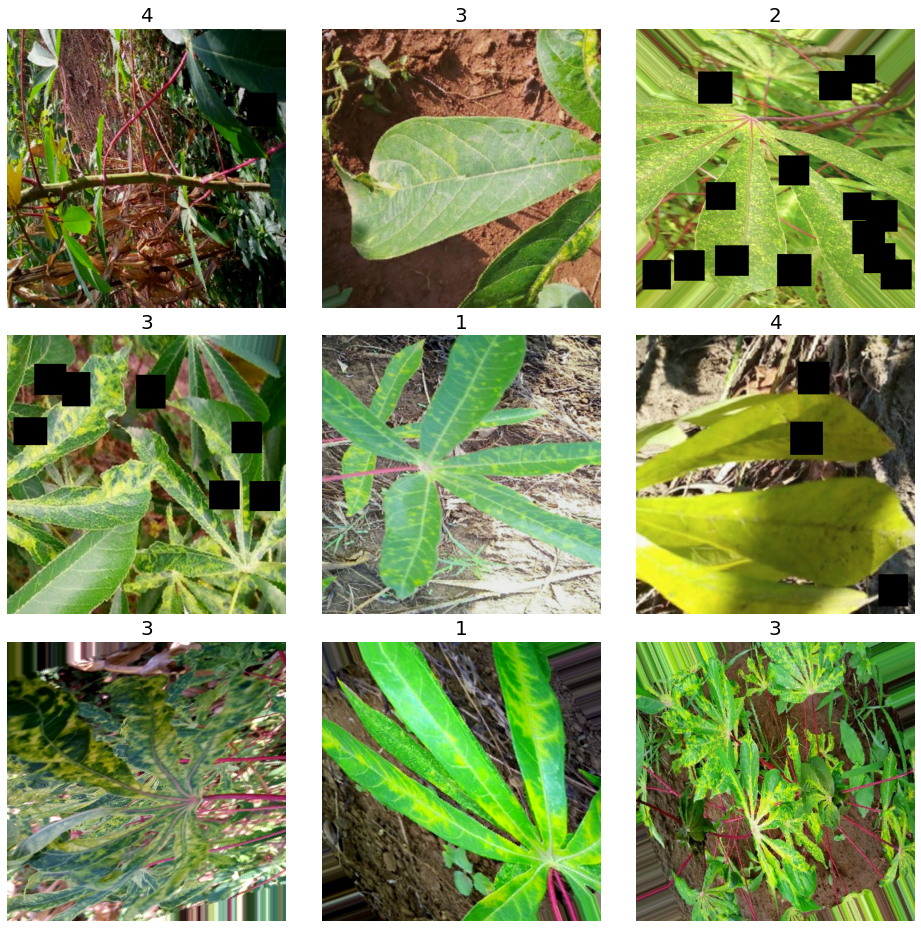

In [17]:
display_batch_of_images(next(train_batch))

# 4. The Training
Here are our amazing plans - 
1. Use kfold crossvalidation. Makes it easy too to use ensemble learning
2. Bring in all the good stuff that people are doing 
3. Use EfficientNetB7, B4, Resnet and try to bring in Resnext

### 1. Callbacks - 

First of we are gonna make a learning rate scheduler callback. Here is what it is gonna do - 

1. Initial lr is 0.1
2. Will store loss in a dict
3. On every 10 batch end if loss did not reduce more than by 0.1 we make lr 10 times the present lr. Then after 3 batches check if lr improved by more than 0.1 or not. If it did we multiply present lr with a decay of 0.01. If it did not we bring back the lr which was there by multiplying present lr by 0.1
3. If after every 10 batch end if loss does improve we decay the present lr by 0.5

We would have liked that but that's much out of my mind how to make that code.
So we are going to go simple like this - 

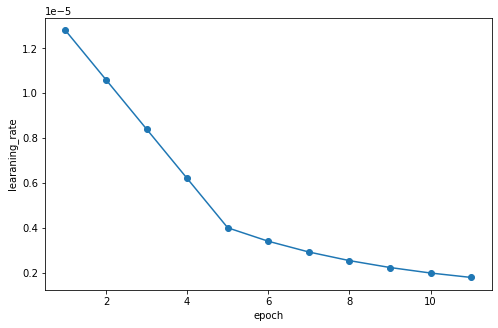

In [18]:
def get_lr_callback(batch_size=8, show = False):
    lr_start   = 0.000015000
    lr_max     = 0.000000250 * strategy.num_replicas_in_sync * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
    if show:
        plt.figure(figsize = (8, 5))
        plt.plot(np.arange(1, 12), [lrfn(x) for x in np.arange(1, 12)], marker = 'o')
        plt.xlabel('epoch')
        plt.ylabel('learaning_rate');
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(batch_size=BATCH_SIZE, show = True)

Next a model checkpoint. But we won't be needing one as the kerastuner package saves everything for us. Next tensorboard and all other good stuff

In [19]:
tensorboard = TensorBoard(log_dir='logs_v0.2/')
reducelr = ReduceLROnPlateau(patience=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience = 3, mode = 'min')

### The model architecture - 

Here is our model architecture basically copied from dimitre oliviera's notebook. Using a enetB4 and dropping out 40 percent. We are gonna freeze the batchnormalization and unfreeze the rest of the conv layers during training.
We might be freezing batchnorms of efficientnet. Here is a good answer why - 

https://stackoverflow.com/questions/63016740/why-its-necessary-to-frozen-all-inner-state-of-a-batch-normalization-layer-when

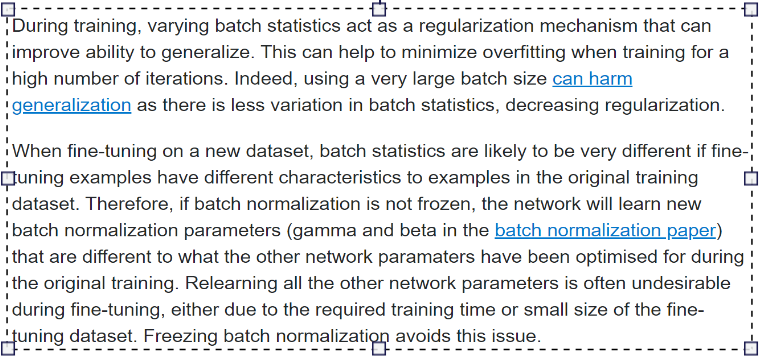

In [ ]:
# from keras.utils.vis_utils import plot_model
def build_model():
    input_shape = (HEIGHT, WIDTH, 3)
    N_CLASSES = 5
    inputs = Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    base_model.trainable = False

    x = Dropout(.4)(base_model.output)
    output = Dense(N_CLASSES, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

Here is our that function i was talking about unfreezing all layers except for batchnormalization.

In [ ]:
def unfreeze_model(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, L.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
                
def unfreeze_block(model, block_name=None, n_top=3):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-n_top]:
        if isinstance(layer, L.BatchNormalization):
            layer.trainable = False
        else:
            if block_name and (block_name in layer.name):
                layer.trainable = True

seed stuff nothing important - 

In [23]:
import random
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)

## K fold cross validation - 
Good articles - 
https://machinelearningmastery.com/out-of-fold-predictions-in-machine-learning/

Good Videos - 

https://www.youtube.com/watch?v=gJo0uNL-5Qw

https://www.youtube.com/watch?v=maiQf8ray_s

Here is a little script to see how it works the splitting.

In [35]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
for fold,(train_idx, val_idx) in enumerate(skf.split(np.arange(16))):
    print('--'*25)
    print(f"FOLD: {fold+1}")
    print(train_idx)
    print(val_idx)

--------------------------------------------------
FOLD: 1
[ 0  2  3  4  5  7 10 11 12 13 14 15]
[1 6 8 9]
--------------------------------------------------
FOLD: 2
[ 0  1  3  5  6  7  8  9 10 11 12 14 15]
[ 2  4 13]
--------------------------------------------------
FOLD: 3
[ 0  1  2  3  4  5  6  8  9 11 12 13 15]
[ 7 10 14]
--------------------------------------------------
FOLD: 4
[ 0  1  2  4  5  6  7  8  9 10 12 13 14]
[ 3 11 15]
--------------------------------------------------
FOLD: 5
[ 1  2  3  4  6  7  8  9 10 11 13 14 15]
[ 0  5 12]


If you remember that our data_fn had 16 filenames. Passing in np.arange(16) and passing in np.arange(data) gives us the same result so we should probably use arange(16) as i think it is gonna be less computationally expensive.

In [36]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
for fold,(train_idx, val_idx) in enumerate(skf.split(data_fn)):
    print('--'*25)
    print(f"FOLD: {fold+1}")
    print(train_idx)
    print(val_idx)

--------------------------------------------------
FOLD: 1
[ 0  2  3  4  5  7 10 11 12 13 14 15]
[1 6 8 9]
--------------------------------------------------
FOLD: 2
[ 0  1  3  5  6  7  8  9 10 11 12 14 15]
[ 2  4 13]
--------------------------------------------------
FOLD: 3
[ 0  1  2  3  4  5  6  8  9 11 12 13 15]
[ 7 10 14]
--------------------------------------------------
FOLD: 4
[ 0  1  2  4  5  6  7  8  9 10 12 13 14]
[ 3 11 15]
--------------------------------------------------
FOLD: 5
[ 1  2  3  4  6  7  8  9 10 11 13 14 15]
[ 0  5 12]


By the way this is what ```np.arange``` does-

In [39]:
print(list(np.arange(16))) # Putting in the list so that it prints the whole output
print(list(np.arange(len(data_fn))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


### The training - 

In [ ]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
for fold,(train_idx, val_idx) in enumerate(skf.split(np.arange(len(DATA))):
